## Import

In [1]:
import uproot as up
from cycler import cycler
import mplhep as hep
import matplotlib.pyplot as plt
import numpy as np
import os
import hist
plt.style.use(hep.style.CMS)

## Define common variables

In [ ]:
processes = ['genbb', 'genb', 'gencc', 'genc',  'genother']

processNames = {
    'genb': 'b',
    'genbb': r'$b\bar{b}$',
    'genc': 'c',
    'gencc': r'$c\bar{c}$',
    'genother': 'light flavor',
}

colorDict = {
    'genbb': '#99ffff',
    'genb': '#ccccff',
    'gencc': '#ffccff',
    'genc': '#ffff99',
    'genother': '#ff9999',
}

## Define useful function

In [ ]:
def plot_postfit(f, year, category, processes, saveplot=False):
    
    fig, (ax, rax) = plt.subplots(2, 1, figsize=(10,10), 
                                  gridspec_kw=dict(height_ratios=[3, 1], hspace=0.07), sharex=True)
    errps = {'hatch':'////', 'facecolor':'none', 'lw': 0, 'color': 'k', 'alpha': 0.3}
    ax.set_ylabel('Events/GeV', fontsize=15)
    ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
    args = {'linestyle':'--', 'linewidth': 5}
    ax.set_yscale('log')
    ax.set_ylim(1e-2, 5e+5)
    hep.cms.label(ax=ax, loc=0,llabel='Preliminary', lumi=lumi, year=year, fontsize=15)

    preidx = 'svmass'+year+category+'_prefit'
    postidx = 'svmass'+year+category+'_postfit'

    predir = f[preidx]
    postdir = f[postidx]
    edges = postdir['TotalBkg'].edges

    process_bin = []
    colors=[]
    mc_list = []

    sum_prefit = np.zeros(len(edges)-1)
    sum_postfit = np.zeros(len(edges)-1)
    sum_postfit_variance = np.zeros(len(edges)-1)

    for process in processes:
        prebin = predir[process].values
        postbin = postdir[process].values
        postfit_bin_variance = np.minimum(postbin, postdir[process].variances)
        process_bin.append(postbin)
        sum_prefit += prebin
        sum_postfit += postbin
        sum_postfit_variance += postfit_bin_variance
        colors.append(colorDict[process])
        mc_list.append(processNames[process])

    colors.reverse()
    ax.set_prop_cycle(cycler(color=colors))

    ### Call data ###
    data = postdir['data_obs'].values
    hep.histplot(data, edges, ax=ax, histtype='errorbar', label="Data", color='k')
    hep.histplot(sum_prefit, edges, ax=ax, label=["SM total (pre-fit)"], color='r', 
                 linestyle='dashed', linewidth=2)
    hep.histplot(sum_postfit, edges, ax=ax, label=["SM total (post-fit)"], color='b', linewidth=3)
    hep.histplot(process_bin, edges, ax=ax, stack=True, 
                     histtype='fill', edgecolor = 'k', linewidth=1, label=mc_list)

    y1 = sum_postfit - np.sqrt(sum_postfit_variance)
    y1 = np.append(y1, 0)
    y2 = sum_postfit + np.sqrt(sum_postfit_variance)
    y2 = np.append(y2, 0)
    ax.fill_between(
        x = edges,
        y1 = y1,
        y2 = y2,
        step = 'post',
        **errps, label='Unc.'
    )

    handles, labels = ax.get_legend_handles_labels()
    order = [8,0,1,2,3,4,5,6,7]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                loc='upper right', fontsize=12, ncol=2) 

    ### Drawing in ratio axes ###
    hep.histplot(data/sum_prefit, edges, yerr=np.sqrt(data)/sum_prefit, ax=rax, histtype='errorbar', 
                 color='r', capsize=4, label="Prefit")
    hep.histplot(data/sum_postfit, edges, yerr=np.sqrt(data)/sum_postfit, ax=rax, histtype='errorbar', 
                 color='b', capsize=4, label="Postfit")

    y1 = 1.- np.sqrt(sum_postfit_variance)/sum_postfit_variance
    y1 = np.append(y1, 0)
    y2 = 1.+ np.sqrt(sum_postfit_variance)/sum_postfit_variance
    y2 = np.append(y2, 0)

    rax.fill_between(
        x = edges,
        y1 = y1,
        y2 = y2,
        step='post',
       **errps, label='Bkg Uncs.'
    )

    rax.axhline(1, ls='--', color='k')
    rax.set_ylim(0.3, 1.6)
    rax.set_xlabel(r'log($m_{SV1,d_{xy}sigmax}$/GeV)', fontsize=15)
    rax.set_ylabel('Obs/Exp', fontsize=15)#, loc='center')
    handles, labels = rax.get_legend_handles_labels()
    order = [1,2,0]
    rax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
               loc='upper right', fontsize=12, ncol=3) 
    
    os.system('mkdir -p ../plots/doublesf/postfit/'+year+'/')
    plot_path = os.path.abspath('../plots/doublesf/postfit/'+year+'/')
    plot_name = category+year+'_svmass.png'
    
    if saveplot:
        fig.savefig(os.path.join(plot_path, plot_name))

In [ ]:
## year, category
year = '2018'
category = 'fail'
lumis = { #Values from https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVAnalysisSummaryTable                                                      
        '2016': "35.92",
        '2017': "41.53",
        '2018': "59.74"
    }
lumi=lumis[year]
saveplot = True
f = up.open("../hists/doublebsf.postfit")

plot_postfit(f, year, category, processes, saveplot)

In [35]:
from coffea import hist, processor 
from coffea.hist import plot
from coffea.util import load, save
plt.style.use(hep.style.CMS)

year = '2018'

hists = load('../hists/doublebsf'+year+'.scaled')
gentype_map = {
    'bb':       0,
    'b':        1,
    'cc' :      2,
    'c':        3,
    'other':    4
}

category_map = {
        "pass": 1,
        "fail": 0
        }
bkg_hists = hists['bkg']
signal_hists = hists['sig']
data_hists = hists['data']

NameError: name 'j' is not defined

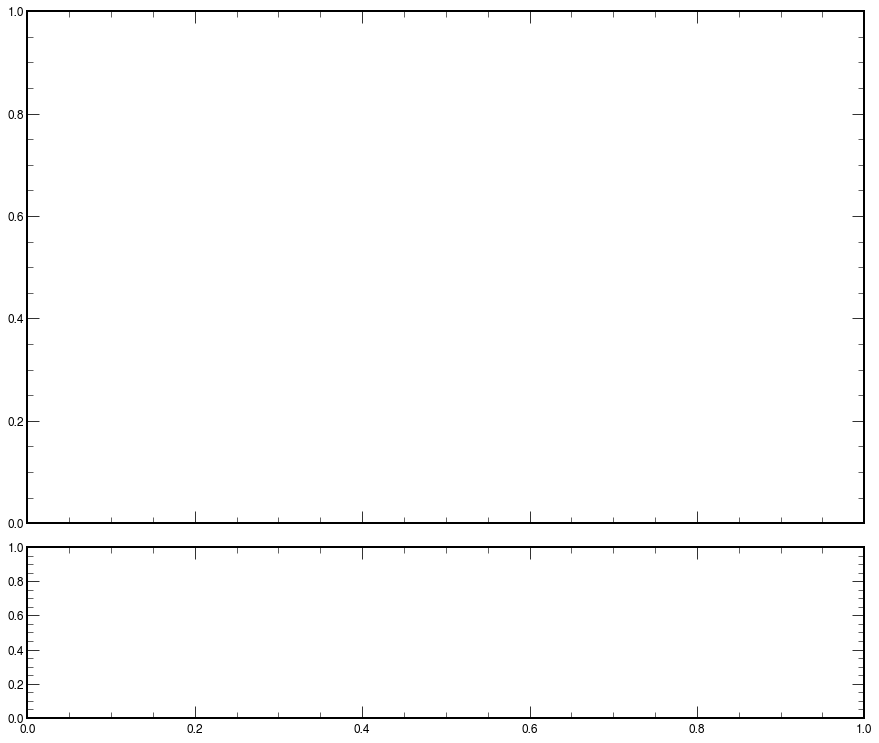

In [10]:
###
# Plot other variables
###
#http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6 : colors
    
from cycler import cycler

fail_binning_dict={
    '2016': [0,0.53],
    '2017': [0,0.61],
    '2018': [0,0.65]
}
pass_binning_dict={
    '2016': [0.53,1],
    '2017': [0.61,1],
    '2018': [0.65,1]
}
fail_binning=fail_binning_dict[year]
pass_binning=pass_binning_dict[year]
    
    
def plot_var(category, var=None):
    
    binning={
        'pass': pass_binning,
        'fail': fail_binning,
    }

    C={
        'pass':'Pass',
        'fail':'Fail',
        '':''
    }
    for key in bkg_hists.keys():
        
        if key=='sumw': continue
        if key=='svtemplate': continue
        if key=='jptemplate': continue
        if key=='cutflow': continue
        if key=='ZHbbvsQCD': continue
        if var and var not in key: continue
        
        #Rebin to pick either pass or fail
        bkg_hists_var=bkg_hists[key]
        bkg_hists_var=bkg_hists_var.sum('gentype')
        data_hists_var=data_hists[key]
        if category is not '':
            bkg_hists_var=bkg_hists_var.rebin('ZHbbvsQCD',hist.Bin('ZHbbvsQCD','ZHbbvsQCD',binning[category]))
            data_hists_var=data_hists_var.rebin('ZHbbvsQCD',hist.Bin('ZHbbvsQCD','ZHbbvsQCD',binning[category]))
        
        plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
        fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
        error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
        nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
        data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
        
        fig, (ax, rax) = plt.subplots(2, 1, figsize=(15,13), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
        fig.subplots_adjust(hspace=.07)
        #ax.set_prop_cycle(cycler(color=colors))
        plot.plot1d(bkg_hists_var.integrate('region',j).sum('ZHbbvsQCD'),
                        overlay="process",
                        ax=ax,
                        clear=False,
                        stack=True,
                        fill_opts=fill_opts,
                        error_opts=error_opts
                   )
        plot.plot1d(data_hists_var.integrate('region',j).sum('ZHbbvsQCD')[data[year][str(j)]],            
                        overlay="process",
                        ax=ax,
                        clear=False,
                        error_opts=data_err_opts
                        )

        plot.plotratio(data_hists_var.integrate('region',j).sum('ZHbbvsQCD').integrate('process',data[year][str(j)]), 
                   bkg_hists_var.integrate('region',j).sum('ZHbbvsQCD').sum('process'),
                   ax=rax,
                   #overflow='over',
                   error_opts=data_err_opts,
                   denom_fill_opts={},
                   guide_opts={},
                   unc='num'
                   )

        rax.set_ylabel('Ratio (data/MC)')
        rax.set_ylim(0.0,2.0)
        rax.grid(axis='y')

        ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
        args = {'linestyle':'--', 'linewidth': 5}
        ax.autoscale(axis='x', tight=True)
        ax.set_yscale('log')
        ax.set_ylim(.1, ax.get_ylim()[1]*100.)
        handles, labels = ax.get_legend_handles_labels()
        order = list(range(len(labels)-1))
        order.insert(0, len(labels)-1)
        ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
                     loc='upper right', fontsize=12, ncol=2)

        #coffee = plt.text(0., 1., u"☕ "+R[str(j).split('_')[0]]+" "+C[category], fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
        #lumitext = plt.text(1., 1., lumi+r" fb$^{-1}$ (13 TeV)", fontsize=17, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)
        if not ('sr' in str(j) and category=='pass'):
            ax.set(xlabel=None)
        ax.set_title(regionDict[str(j)+'_'+category], loc='center', fontsize=18)
        hep.cms.text(ax=ax, loc=0, text='Preliminary',fontsize=18)
        hep.cms.lumitext(ax=ax, text=lumi+r" fb$^{-1}$, "+year+" (13 TeV)",fontsize=18)
        #os.system('mkdir -p ../plots/darkhiggs/prefit/'+year+'/')
        #plot_path = os.path.abspath('../plots/darkhiggs/prefit/'+year+'/') 
        #plot_name = 'stack_'+str(j)+'_'+category+'_'+key+'.png'
        #fig.savefig(os.path.join(plot_path, plot_name))
        
plot_var('pass')
plot_var('fail')

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary'))

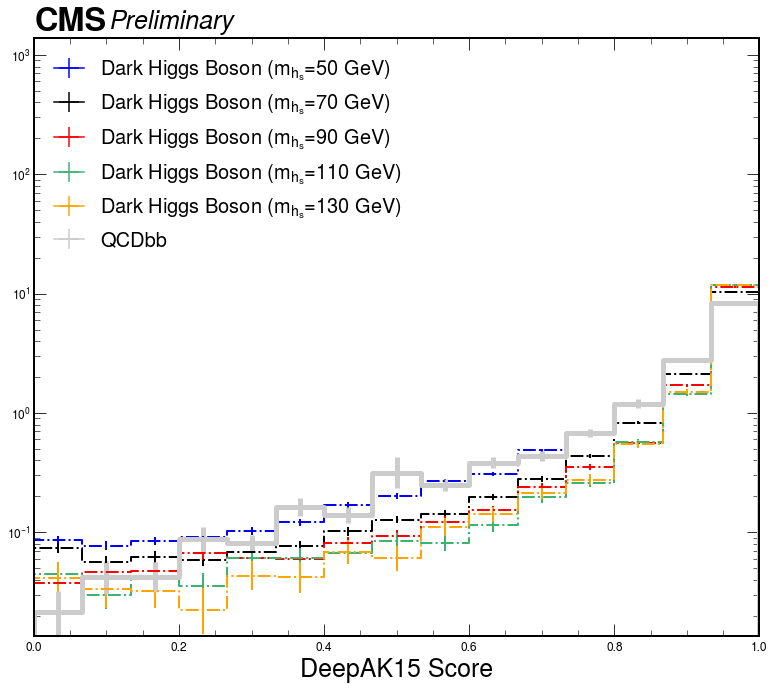

In [40]:
###
# N-1 of the fat jet tagger unstack plot
###
#http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6 : colors
    
from cycler import cycler
from collections import defaultdict, OrderedDict
from coffea import hist, processor 
from coffea.hist import plot

process = hist.Cat("process", "Process", sorting="placement")
cats = ("process",)

bkg_hists_ZHbbvsQCD=bkg_hists['ZHbbvsQCD'].rebin('gentype',hist.Bin('gentype', 'Gen Type', [0, 1]))
bkg_hists_ZHbbvsQCD=bkg_hists_ZHbbvsQCD.sum('gentype')#.integrate('ZHbbvsQCD')
bkg_map = OrderedDict()
bkg_map["QCDbb"] = ("QCD*",)
bkg_hists_ZHbbvsQCD=bkg_hists_ZHbbvsQCD.group(cats, process, bkg_map)

signal_hists_ZHbbvsQCD=signal_hists['ZHbbvsQCD'].rebin('gentype',hist.Bin('gentype', 'Gen Type', [5, 6]))
signal_hists_ZHbbvsQCD=signal_hists_ZHbbvsQCD.sum('gentype')#.integrate('ZHbbvsQCD')
signal_map = OrderedDict()
signal_map[r"Dark Higgs Boson ($m_{h_s}$=50 GeV)"] = ("Mz500_mhs50_Mdm150*",)
signal_map[r"Dark Higgs Boson ($m_{h_s}$=70 GeV)"] = ("Mz500_mhs70_Mdm150*",)
signal_map[r"Dark Higgs Boson ($m_{h_s}$=90 GeV)"] = ("Mz500_mhs90_Mdm150*",)
signal_map[r"Dark Higgs Boson ($m_{h_s}$=110 GeV)"] = ("Mz500_mhs110_Mdm150*",)
signal_map[r"Dark Higgs Boson ($m_{h_s}$=130 GeV)"] = ("Mz500_mhs130_Mdm150*",)
signal_hists_ZHbbvsQCD=signal_hists_ZHbbvsQCD.group(cats, process, signal_map)
        
plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':'k'}#, 'elinewidth': 1, 'emarker': '_'}
colors = ['#0000ff','#000000','#ff0000','#3cb371','#FFA500','#cccccc']


fig, ax = plt.subplots(figsize=(13,11), sharex=True)
ax.set_prop_cycle(cycler(color=colors))

line_opts = {'linestyle':'dashdot', 'linewidth':2}
line_opts2 = {'linestyle':'-', 'linewidth':5}
error_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10.}

plot.plot1d(signal_hists_ZHbbvsQCD,
                overlay="process",
                ax=ax,
                error_opts=error_opts,
                clear=False,
                density=True,
                line_opts=line_opts,
                )
plot.plot1d(bkg_hists_ZHbbvsQCD,
                overlay="process",
                ax=ax,
                error_opts=error_opts,
                clear=False,
                density=True,
                line_opts=line_opts2,
                )

ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
args = {'linestyle':'--', 'linewidth': 5}
ax.autoscale(axis='x', tight=True)
ax.set_yscale('log')
ax.set_ylabel("",fontsize=25)
ax.set_ylim(.0, ax.get_ylim()[1]*110)
ax.set_xlabel("DeepAK15 Score",fontsize=25)
ax.set_xlim(.0, 1.)
leg = ax.legend(ncol=1, loc='upper left',fontsize=20)
hep.cms.text(ax=ax, loc=0, text='Preliminary',fontsize=25)

#coffee = plt.text(0., 1., u"☕ "+'Signal Region', fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
#lumitext = plt.text(1., 1., lumi+r" fb$^{-1}$ (13 TeV)", fontsize=17, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

#os.system('mkdir -p ../plots/darkhiggs/prefit/'+year+'/')
#plot_path = os.path.abspath('../plots/darkhiggs/prefit/'+year+'/') 
#plot_name = 'unstack_sr_ZHbbvsQCD.png'
#fig.savefig(os.path.join(plot_path, plot_name))




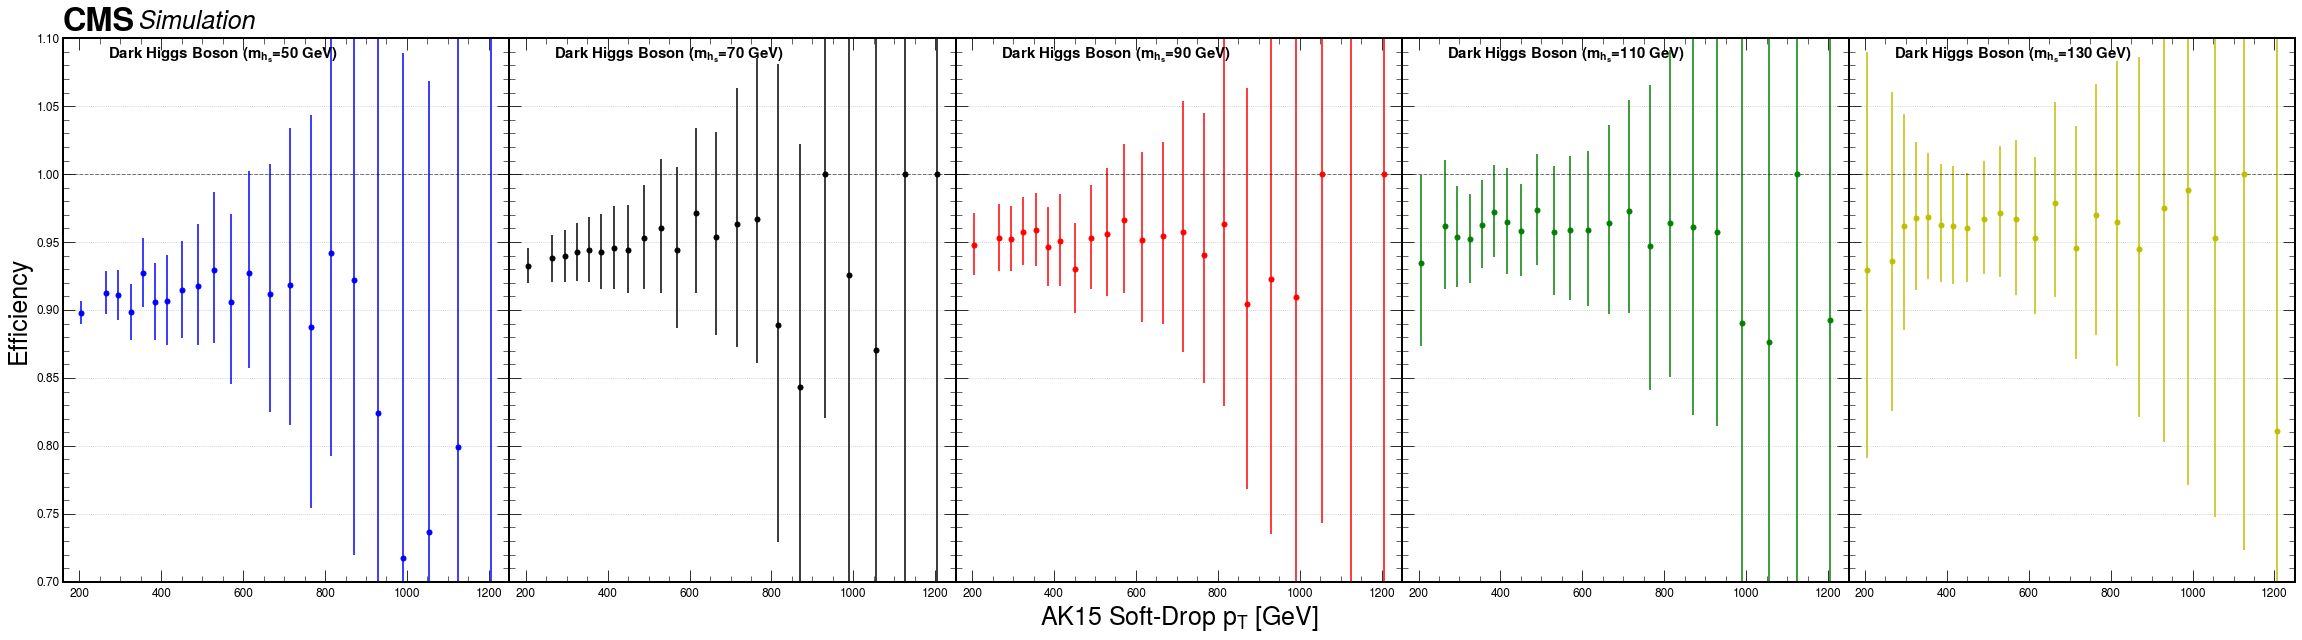

In [39]:
###
# Plot efficiency as a function of fatjet pT
###
fail_binning_dict={
    '2016': [0,0.53],
    '2017': [0,0.61],
    '2018': [0,0.65]
}
pass_binning_dict={
    '2016': [0.53,1],
    '2017': [0.61,1],
    '2018': [0.65,1]
}
fail_binning=fail_binning_dict[year]
pass_binning=pass_binning_dict[year]

def plot_eff():
    
    def fill(ax,mass,color):
        pass_hists  = {}
        fail_hists  = {}

        signal_hists_fj1pt=signal_hists['fj1pt'].rebin('gentype',hist.Bin('gentype', 'Gen Type', [5, 6]))
        signal_hists_fj1pt=signal_hists_fj1pt.sum('gentype')
        #signal_hists_fj1pt=signal_hists_fj1pt.rebin('fj1pt',hist.Bin('fj1pt', 'fj1pt', [250,370,470,1250]))
        signal_map = OrderedDict()
        signal_map[r"Dark Higgs Boson ($m_{h_s}$=50 GeV)"] = ("Mz500_mhs50_Mdm150*",)
        signal_map[r"Dark Higgs Boson ($m_{h_s}$=70 GeV)"] = ("Mz500_mhs70_Mdm150*",)
        signal_map[r"Dark Higgs Boson ($m_{h_s}$=90 GeV)"] = ("Mz500_mhs90_Mdm150*",)
        signal_map[r"Dark Higgs Boson ($m_{h_s}$=110 GeV)"] = ("Mz500_mhs110_Mdm150*",)
        signal_map[r"Dark Higgs Boson ($m_{h_s}$=130 GeV)"] = ("Mz500_mhs130_Mdm150*",)
        signal_hists_fj1pt=signal_hists_fj1pt.group(cats, process, signal_map)
        
        signal_hists_pass=signal_hists_fj1pt.rebin('ZHbbvsQCD',hist.Bin('ZHbbvsQCD','ZHbbvsQCD',pass_binning))
        signal_hists_pass=signal_hists_pass.sum('ZHbbvsQCD')
        signal_hists_tot=signal_hists_fj1pt.sum('ZHbbvsQCD')
        #signal_eff=signal_hists_pass
        #for p in signal_eff.identifiers('process'):
        #    signal_eff.values()[(str(p),)]/=signal_hists_tot.values()[(str(p),)]
        #    errors=0.02
        #    centers = signal_hists_pass.axis('fj1pt').edges()[:-1] + np.diff(signal_hists_pass.axis('fj1pt').edges())/2
            #ax.errorbar(centers, signal_eff.values()[(str(p),)], yerr=errors, fmt='none')#, c=s.get_color())

        #http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6 : colors
        from cycler import cycler

        plt.rcParams.update({'figure.max_open_warning': 0,'font.size': 14, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
        fill_opts = {'edgecolor': (0,0,0,0.3), 'alpha': 1}
        nostack_fill_opts = {'alpha': 0.2, 'label': '_nolabel_'}
        data_err_opts = {'linestyle':'None', 'marker': '.', 'markersize': 10., 'color':color}#, 'elinewidth': 1, 'emarker': '_'}
        colors = ['#a6cee3', '#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f']
        ax.set_prop_cycle(cycler(color=colors))
    
        #plot = hist.plot1d(signal_eff,
                    #overlay="process",
                    #ax=ax,
                    #line_opts=line_opts2,
                    #error_opts=error_opts,
                    #overflow='over',
                    #error_opts=data_err_opts,
                    #denom_fill_opts={},
                    #guide_opts={},
                    #unc='num'
                    #)
        
        plot.plotratio(signal_hists_pass.integrate('process',r"Dark Higgs Boson ($m_{h_s}$="+mass+" GeV)"),
                    signal_hists_tot.integrate('process',r"Dark Higgs Boson ($m_{h_s}$="+mass+" GeV)"),
                    ax=ax,
                    #overflow='over',
                    error_opts=data_err_opts,
                    denom_fill_opts={"facecolor": (0, 0, 0, 0)},
                    guide_opts={},
                    unc='num'
                    )
        
        #for p in signal_hists_tot.identifiers('process'):
        #    A = signal_hists_pass.values()[(str(p),)]
        #    B = signal_hists_tot.values()[(str(p),)]
        #    sigma_A = np.sqrt(A)
        #    sigma_B = np.sqrt(B)
        #    f = A/B
        #    err = np.sqrt((sigma_A/A)**2 + (sigma_B/B)**2)
        #    hep.histplot(f, signal_hists_pass.axis('fj1pt').edges(), yerr=err, ax=ax, histtype='errorbar', capsize=4)
            
        ax.set_ylim(0.7,1.1)
        ax.grid(axis='y')
        ax._get_lines.prop_cycler = ax._get_patches_for_fill.prop_cycler
        #args = {'linestyle':'--', 'linewidth': 5}
        ax.autoscale(axis='x', tight=True)
        ax.text(s=r"Dark Higgs Boson ($m_{h_s}$="+mass+" GeV)", y=1.085, x=270, fontsize=15, weight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('')
    
    fig, axs = plt.subplots(1, 5, figsize=(40,10), sharey='row',
                            gridspec_kw=dict(wspace=0.))
    ax=axs[0]
    fill(ax,'50','b')
    ax.set_ylabel('Efficiency', fontsize=25)
    hep.cms.text(ax=ax, loc=0, text='Simulation',fontsize=25)
    ax=axs[1]
    fill(ax,'70','k')
    ax=axs[2]
    fill(ax,'90','r')
    #ax.set_title(vj, loc='center', fontsize=25)
    ax.set_xlabel(r'AK15 Soft-Drop $p_T$ [GeV]', fontsize=25)
    ax=axs[3]
    fill(ax,'110','g')
    ax=axs[4]
    fill(ax,'130','y')
    
    
    #coffee = plt.text(0., 1., u"☕ "+'Pass/Fail Ratio, Recoil '+str(recoil), fontsize=20, horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    #os.system('mkdir -p ../plots/darkhiggs/systematics/'+year+'/')
    #plot_path = os.path.abspath('../plots/darkhiggs/systematics/'+year+'/')
    #plot_name = '1Dratio_'+vj+'.png'
    #fig.savefig(os.path.join(plot_path, plot_name))

plot_eff()